# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%%script false
from unityagents import UnityEnvironment
import numpy as np


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
%%script false
env = UnityEnvironment(file_name="Banana.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
%%script false
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
%%script false
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
%%script false
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
env.close()
print("Score: {}".format(score))

### 4. Training

In [6]:
import numpy as np
import time
import random
from collections import namedtuple, deque
from unityagents import UnityEnvironment

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 0
if torch.cuda.is_available:
    torch.cuda.manual_seed(seed)  
torch.manual_seed(seed)


In [7]:
class DuelQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden=[100,64,64,64,64], value=[64], advantage=[64]):
        super(DuelQNetwork,self).__init__()
        
        hidden = list(hidden)
        value = list(value)
        advantage = list(advantage)

        
        self.state_size = state_size
        self.action_size = action_size
        
        
        self.seed = torch.manual_seed(seed)

        self.input = nn.Linear(state_size, hidden[0])
        self.dropout = nn.Dropout(p=0.3)
        self.hidden = nn.ModuleList([nn.Linear(hidden[i],hidden[i+1]) for i in range(len(hidden)-1)])
        
        value.insert(0,hidden[-1])
        value.append(1)
        self.value = nn.ModuleList([nn.Linear(value[i],value[i+1]) for i in range(len(value)-1)])
        
        advantage.insert(0,hidden[-1])
        advantage.append(action_size)
        self.advantage = nn.ModuleList([nn.Linear(advantage[i],advantage[i+1]) for i in range(len(advantage)-1)])
        
    def forward(self,state):
        x = state
        x = F.relu(self.input(x))
        x = self.dropout(x)
        
        for layer in self.hidden:
            x = F.relu(layer(x))
        
        a = x
        for layer in self.advantage:
            a = F.relu(layer(a)) if layer != self.advantage[-1] else layer(a)
        
        v = x
        for layer in self.value:
            v = F.relu(layer(v)) if layer != self.value[-1] else layer(v)
        
        return a+v

In [8]:
class ExperienceBuffer:
    def __init__(self, batch_size = 128, buffer_size = 10000, min_delta=1e-5):
        self.batch_size = batch_size
        self.min_delta = min_delta
        
        self.buffer = deque(maxlen=buffer_size)
        self.deltas = deque(maxlen=buffer_size)
        
        self.exp_template = namedtuple("exp", field_names=["state","action","reward","new_state","done"])
    
    def add(self, state, action, reward, new_state, done):
        exp = self.exp_template(state, action, reward, new_state, int(done))
        self.buffer.append(exp)
        self.deltas.append( max(self.deltas) if len(self.deltas) > 0 else self.min_delta )
    
    def sample(self,priority=0.5):
        #TODO: sample based on delta
       
        deltas = np.array(self.deltas)
        probs = deltas**priority / np.sum(deltas**priority)
        
        exp_batch_idx = np.random.choice(np.arange(len(self.buffer)), size=self.batch_size, p=probs, replace=False)
         
        states = torch.from_numpy(np.vstack([self.buffer[idx].state for idx in exp_batch_idx])).float().to(device)
        actions = torch.from_numpy(np.vstack([self.buffer[idx].action for idx in exp_batch_idx])).long().to(device)
        rewards = torch.from_numpy(np.vstack([self.buffer[idx].reward for idx in exp_batch_idx])).float().to(device)
        new_states = torch.from_numpy(np.vstack([self.buffer[idx].new_state for idx in exp_batch_idx])).float().to(device)
        dones = torch.from_numpy(np.vstack([self.buffer[idx].done for idx in exp_batch_idx])).float().to(device)
        probabilities = torch.from_numpy(np.vstack([probs[idx] for idx in exp_batch_idx])).float().to(device)
        
        return states, actions, rewards, new_states, dones, probabilities, exp_batch_idx
    
    def update_deltas(self,idxs,deltas):
        for i,idx in enumerate(idxs):
            self.deltas[idx] = deltas[i] + self.min_delta
    
    def __len__(self):
        return len(self.buffer)

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size, num_episodes, gamma=0.99, lr=5e-4, batch_size=64, learn_every=4, global_update_rate=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.learn_every = learn_every
        self.global_update_rate = global_update_rate
        
        self.seed = 0
        self.local_network = DuelQNetwork(state_size,action_size,self.seed).to(device)
        self.global_network = DuelQNetwork(state_size,action_size,self.seed).to(device)
        self.optimizer = optim.Adam(self.local_network.parameters(), lr=lr)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=num_episodes, eta_min=1e-10)
        #self.lr_scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.995)
        
        print(self.local_network)
        
        self.experience_buffer = ExperienceBuffer(batch_size=self.batch_size)
        self.i_step = 0
        self.loss_list = []
        self.entropy_list = []
    
    def adjust_lr(self,episode):
        self.lr_scheduler.step(episode)
        return self.lr_scheduler.get_lr()[0]
    
    def step(self, state, action, reward, new_state, done, weight_importance=0.5, priority=0.5):
        self.experience_buffer.add(state, action, reward, new_state, done)
        self.i_step = ( self.i_step + 1 ) % self.learn_every
        if self.i_step == 0:
            if len(self.experience_buffer)>self.batch_size:
                exp_batch = self.experience_buffer.sample(priority)
                self.learn(exp_batch,weight_importance)
    
    def choose_action(self, state, epsilon=0.):
        rnd = random.random()
        #print(epsilon, rnd, self.action_size)
        if rnd < epsilon:
            return random.choice(np.arange(self.action_size))
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_network.eval()
        with torch.no_grad():
            action_values = self.local_network(state)
        self.local_network.train()
        return int(torch.argmax(action_values).numpy())
    
    def learn(self, exp_batch, weight_importance=0.5):
        states, actions, rewards, new_states, dones, probs, exp_idxs = exp_batch
        
        # Get next action values
        next_action_values_local = self.local_network(new_states).detach()
        next_best_action_idxs = torch.argmax(next_action_values_local,1)

        
        # get best action indexes & values
        next_action_values = self.global_network(new_states).detach()
        Q_target_next = next_action_values.gather(1, next_best_action_idxs.unsqueeze(1))
        
        Q_targets = rewards + ( self.gamma * Q_target_next * (1-dones))
        
        predict = self.local_network(states)
        Q_current = predict.gather(1, actions)
    
        #TODO: push deltas back to eperience buffer
        td_error = (Q_targets - Q_current)
        new_deltas = torch.abs(td_error.detach().squeeze(1)).numpy()
        self.experience_buffer.update_deltas(exp_idxs,new_deltas)
        
        #print("new_deltas", new_deltas)
        # Optimize - Weighted mse loss
        self.optimizer.zero_grad()
        batch_loss = td_error ** 2
        weights = ( (1/len(self.experience_buffer)) * (1/probs) )**weight_importance
        #print("weights", weights)
        loss = torch.mean(batch_loss * weights)
        loss.backward()
        self.loss_list.append(loss.item())
        self.optimizer.step()
        
        with torch.no_grad():
            self.entropy_list.append( F.cross_entropy(predict,actions.squeeze(1)).numpy() )
        
        # Perform update
        self.soft_update()
        
    def soft_update(self):
        tau = self.global_update_rate
        for local_params, global_params in zip(self.local_network.parameters(), self.global_network.parameters()):
            global_params.data.copy_( tau * local_params.data + (1-tau)*global_params.data )        
        
        
        

In [10]:
env = UnityEnvironment(file_name="Banana.app");
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [11]:
num_episodes = 1800
max_steps = 300

agent = DQNAgent(state_size, action_size, num_episodes)

priority_start=0.5
priority_end=0.5
priority_decay = 0.99

weight_importance_start=0.5
weight_importance_end=1.0
weight_importance_decay = 0.99

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.99

print_every=10
average_last_N=100
score_list = []
lr_list = []

eps = eps_start
pri = priority_start
wi = weight_importance_start

last_saved_score = 0

session_ts = str(int(time.time()))

for i_episode in range(num_episodes):
    step_info = env.reset(train_mode=True)[brain_name]
    state = step_info.vector_observations[0]
    score = 0
    lr_list.append(agent.adjust_lr(i_episode))
    for i_step in range(max_steps):
        #print(f"\rStep: {i_step}/{max_steps}", end="")
        action = agent.choose_action(state,eps)
        
        step_info = env.step(action)[brain_name]
        new_state = step_info.vector_observations[0]   
        reward = step_info.rewards[0]                    
        done = step_info.local_done[0]   
        agent.step(state,action,reward,new_state,done,wi,pri)
        
        score += reward                                # update the score
        state = new_state                
        if done:
            score_list.append(score)
            break
    
    eps = max(eps_end, eps*eps_decay)
    pri = 0 #min(priority_end, pri/priority_decay)
    wi = 0 #min(weight_importance_end, wi/weight_importance_decay)
    
    if i_episode % print_every == 0:
        score_avg = np.average(score_list[-average_last_N:])
        entropy_avg = np.average(agent.entropy_list[-average_last_N:])
        loss_avg = np.average(agent.loss_list[-average_last_N:])
        last_lr = lr_list[-1]
        print(f"EP: {i_episode}/{num_episodes} - Score: {score_avg:.2f} - Entropy: {entropy_avg:.5f} - Loss: {loss_avg:.5f} - EPS: {eps:.2f} - LR: {last_lr:.3e} - Pri: {pri:.3f} - WI:{wi:.3f}")
        if score_avg > 13 and score_avg > last_saved_score:
            last_saved_score = score_avg
            name = f"checkpoint_{session_ts}-ep_{i_episode}-score_{score_avg:.3f}.pth"
            print('Saving Checkpoint:', name)
            torch.save(agent.local_network.state_dict(), name)

DuelQNetwork(
  (input): Linear(in_features=37, out_features=100, bias=True)
  (dropout): Dropout(p=0.3)
  (hidden): ModuleList(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (value): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
  (advantage): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=4, bias=True)
  )
)
EP: 0/1800 - Score: 1.00 - Entropy: 1.38469 - Loss: 0.00533 - EPS: 0.99 - LR: 5.000e-04 - Pri: 0.000 - WI:0.000
EP: 10/1800 - Score: 0.00 - Entropy: 1.38612 - Loss: 0.00244 - EPS: 0.90 - LR: 5.000e-04 - Pri: 0.000 - WI:0.000
EP: 20/1800 - Score: 0.05 - Entropy: 1.38609 - Loss: 0.00333 - EPS: 0.81 - LR: 4.998e-04 - Pri: 0.000 -

EP: 610/1800 - Score: 15.11 - Entropy: 1.27390 - Loss: 0.02901 - EPS: 0.01 - LR: 3.712e-04 - Pri: 0.000 - WI:0.000
Saving Checkpoint: checkpoint_1534813065-ep_610-score_15.110.pth
EP: 620/1800 - Score: 15.20 - Entropy: 1.28185 - Loss: 0.02638 - EPS: 0.01 - LR: 3.674e-04 - Pri: 0.000 - WI:0.000
Saving Checkpoint: checkpoint_1534813065-ep_620-score_15.200.pth
EP: 630/1800 - Score: 15.14 - Entropy: 1.28999 - Loss: 0.02784 - EPS: 0.01 - LR: 3.635e-04 - Pri: 0.000 - WI:0.000
EP: 640/1800 - Score: 15.05 - Entropy: 1.29514 - Loss: 0.02956 - EPS: 0.01 - LR: 3.596e-04 - Pri: 0.000 - WI:0.000
EP: 650/1800 - Score: 14.95 - Entropy: 1.29339 - Loss: 0.03032 - EPS: 0.01 - LR: 3.557e-04 - Pri: 0.000 - WI:0.000
EP: 660/1800 - Score: 15.16 - Entropy: 1.29518 - Loss: 0.03394 - EPS: 0.01 - LR: 3.517e-04 - Pri: 0.000 - WI:0.000
EP: 670/1800 - Score: 15.07 - Entropy: 1.27957 - Loss: 0.03172 - EPS: 0.01 - LR: 3.477e-04 - Pri: 0.000 - WI:0.000
EP: 680/1800 - Score: 15.04 - Entropy: 1.27622 - Loss: 0.03882 - 

EP: 1250/1800 - Score: 16.04 - Entropy: 1.28174 - Loss: 0.05777 - EPS: 0.01 - LR: 1.066e-04 - Pri: 0.000 - WI:0.000
EP: 1260/1800 - Score: 16.20 - Entropy: 1.27981 - Loss: 0.05700 - EPS: 0.01 - LR: 1.031e-04 - Pri: 0.000 - WI:0.000
EP: 1270/1800 - Score: 16.13 - Entropy: 1.29004 - Loss: 0.05552 - EPS: 0.01 - LR: 9.955e-05 - Pri: 0.000 - WI:0.000
EP: 1280/1800 - Score: 15.91 - Entropy: 1.29787 - Loss: 0.03947 - EPS: 0.01 - LR: 9.608e-05 - Pri: 0.000 - WI:0.000
EP: 1290/1800 - Score: 15.78 - Entropy: 1.29678 - Loss: 0.05082 - EPS: 0.01 - LR: 9.267e-05 - Pri: 0.000 - WI:0.000
EP: 1300/1800 - Score: 15.98 - Entropy: 1.29727 - Loss: 0.05704 - EPS: 0.01 - LR: 8.930e-05 - Pri: 0.000 - WI:0.000
EP: 1310/1800 - Score: 16.37 - Entropy: 1.28822 - Loss: 0.04997 - EPS: 0.01 - LR: 8.599e-05 - Pri: 0.000 - WI:0.000
EP: 1320/1800 - Score: 16.40 - Entropy: 1.28028 - Loss: 0.04232 - EPS: 0.01 - LR: 8.272e-05 - Pri: 0.000 - WI:0.000
EP: 1330/1800 - Score: 16.53 - Entropy: 1.27298 - Loss: 0.05461 - EPS: 0

In [12]:
env.close()

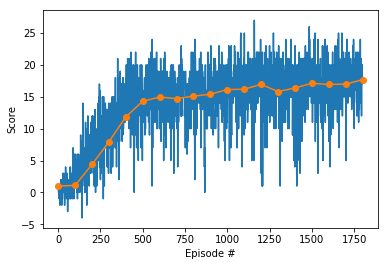

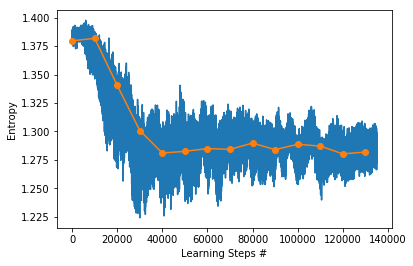

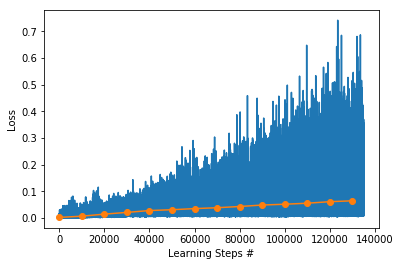

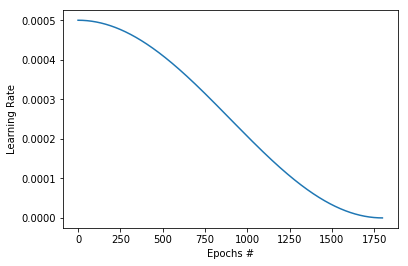

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

avg_scores_x = list(range(0,num_episodes+1,average_last_N))
avg_scores_y = [score_list[0]]
for i in range(len(avg_scores_x)-1):
    avg_scores_y.append(np.mean(score_list[avg_scores_x[i]:avg_scores_x[i+1]]))
    
avg_entropy_x = list(range(0,len(agent.entropy_list)+1,average_last_N*100))
avg_entropy_y = [agent.entropy_list[0]]
for i in range(len(avg_entropy_x)-1):
    avg_entropy_y.append(np.mean(agent.entropy_list[avg_entropy_x[i]:avg_entropy_x[i+1]]))
    
avg_loss_x = list(range(0,len(agent.loss_list)+1,average_last_N*100))
avg_loss_y = [agent.loss_list[0]]
for i in range(len(avg_entropy_x)-1):
    avg_loss_y.append(np.mean(agent.loss_list[avg_loss_x[i]:avg_loss_x[i+1]]))

    
fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(score_list)), score_list)
plt.plot(avg_scores_x,avg_scores_y,'-o') 
plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.show()

fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(agent.entropy_list)), agent.entropy_list)
plt.plot(avg_entropy_x,avg_entropy_y,'-o') 
plt.ylabel('Entropy')
plt.xlabel('Learning Steps #')
#plt.show()

fig = plt.figure(3)
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(agent.loss_list)), agent.loss_list)
plt.plot(avg_loss_x,avg_loss_y,'-o') 
plt.ylabel('Loss')
plt.xlabel('Learning Steps #')
plt.show()

fig = plt.figure(3)
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(len(lr_list)), lr_list,'-')
plt.ylabel('Learning Rate')
plt.xlabel('Epochs #')
plt.show()
